<a href="https://colab.research.google.com/github/lnsprnz/MantisAI/1_5_modelTesting/MantisKeypointsTest/Mantis_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mantis Keypoint Detection with Transfer Learning

**Description:** Training a keypoint detector with data augmentation and transfer learning. Based on https://keras.io/examples/vision/keypoint_detection/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install the imgaug package

In [2]:
!pip install -q -U imgaug

In [3]:
from keras import layers
import keras

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

# Define hyperparameters:
IMG_SIZE: length and width of the Mantis Images

BATCH_SIZE

EPOCH

NUM_KEYPOINTS: Number of Keypoints to detect. In this work we need to detect 5 Keypoints

In [68]:
IMG_SIZE = 640
BATCH_SIZE = 1
EPOCHS = 5
NUM_KEYPOINTS = 5 * 2  # 5 pairs each having x and y coordinates

## Load data

The authors also provide a metadata file that specifies additional information about the
keypoints, like color information, animal pose name, etc. We will load this file in a `pandas`
dataframe to extract information for visualization purposes.

In [81]:
IMG_DIR = "/content/drive/MyDrive/MantisImages"
JSON = "/content/drive/MyDrive/MantisAnnotations.json"
KEYPOINT_DEF = (
    "/content/drive/MyDrive/MantisKeypointDef.csv"
)

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Prepare the mapping for images and annotations
images = {image['id']: image for image in json_data['images']}
annotations = {annotation['image_id']: annotation for annotation in json_data['annotations']}

# Process keypoints to ensure they are 2D
raw_keypoints = annotation.get('keypoints', [])
if raw_keypoints:
  # Reshape the keypoints into a 2D array with shape (num_keypoints, 3)
  reshaped_keypoints = [raw_keypoints[i:i + 3] for i in range(0, len(raw_keypoints), 3)]
else:
  reshaped_keypoints = []

# Generate the desired output structure
json_dict = {}
for image_id, image_data in images.items():
    annotation = annotations.get(image_id, {})

    # Map the image and annotation data to the desired structure
    json_dict[image_data['file_name']] = {
        'img_bbox': annotation.get('bbox', []),
        'img_height': image_data['height'],
        'img_path': image_data['file_name'],
        'img_width': image_data['width'],
        'joints': annotation.get('keypoints', [])
    }

# Example: Accessing a single entry from json_dict
for path, entry in json_dict.items():
    print(f"'{path}': {entry}")
    joints = entry.get('joints', [])
    joints_array = np.array(joints)

    # Print the information
    print(f"Image Path: {path}")
    print(f"Joints Array:\n{joints_array}")
    print(f"Shape: {joints_array.shape}")
    break  # Just show one example


'Hyosicorypha_gracilis_D4_F3_S1_23-07-21_C001H001S0001000857_jpg.rf.3d16b62acdbd6d02607bd57002767166.jpg': {'img_bbox': [318, 151, 261, 182], 'img_height': 640, 'img_path': 'Hyosicorypha_gracilis_D4_F3_S1_23-07-21_C001H001S0001000857_jpg.rf.3d16b62acdbd6d02607bd57002767166.jpg', 'img_width': 640, 'joints': [573.114, 188.581, 2, 400.356, 268.566, 2, 409.244, 162.787, 2, 390.169, 287.424, 2, 352.236, 305.415, 2]}
Image Path: Hyosicorypha_gracilis_D4_F3_S1_23-07-21_C001H001S0001000857_jpg.rf.3d16b62acdbd6d02607bd57002767166.jpg
Joints Array:
[573.114 188.581   2.    400.356 268.566   2.    409.244 162.787   2.
 390.169 287.424   2.    352.236 305.415   2.   ]
Shape: (15,)


A single entry of `json_dict` looks like the following:

```
'Hyosicorypha_gracilis_D4_F3_S1_23-07-21_C001H001S0001000857_jpg.rf.3d16b62acdbd6d02607bd57002767166.jpg':
{
    "img_bbox": [318, 151, 261, 182],
    "img_height": 640,
    "img_path": "Hyosicorypha_gracilis_D4_F3_S1_23-07-21_C001H001S0001000857_jpg.rf.3d16b62acdbd6d02607bd57002767166.jpg",
    "img_width": 640,
    "joints": [
        [573.114, 188.581, 2],
        [400.356, 268.566, 2],
        [409.244, 162.787, 2],
        [390.169, 287.424, 2],
        [352.236, 305.415, 2]
    ],
}
```

In this example, the keys we are interested in are:

* `img_path`
* `joints`

There are a total of 24 entries present inside `joints`. Each entry has 3 values:

* x-coordinate
* y-coordinate
* visibility flag of the keypoints (1 indicates visibility and 0 indicates non-visibility)

As we can see `joints` contain multiple `[0, 0, 0]` entries which denote that those
keypoints were not labeled. In this example, we will consider both non-visible as well as
unlabeled keypoints in order to allow mini-batch learning.

In [82]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex color"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()


# Utility for reading an image and for getting its annotations.
def get_mantis(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data


## Visualize data

Now, we write a utility function to visualize the images and their keypoints.

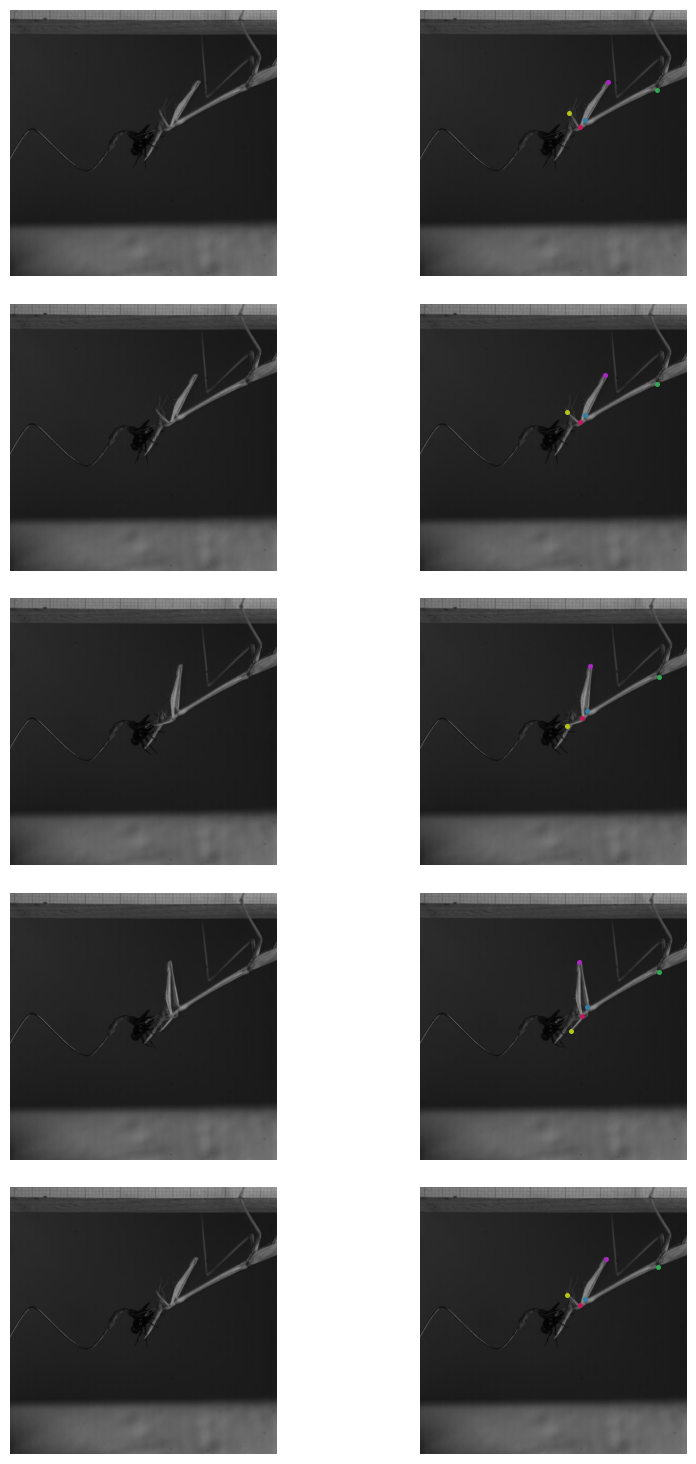

In [83]:

# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(10, 15))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        current_keypoint = np.array(current_keypoint)
        current_keypoint = current_keypoint.reshape(-1, 3)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x],
                    [kp.y],
                    c=colours[idx],
                    marker="x",
                    s=50,
                    linewidths=5,
                )
        else:
            current_keypoint = np.array(current_keypoint)
            for idx, (x, y, v) in enumerate(current_keypoint):
              if v == 2:
                ax_all.scatter([x], [y], c=colours[idx], marker=".", s=10, linewidths=2)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 5
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_mantis(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In the next section, we will write a data generator inheriting the
[`keras.utils.Sequence`](https://keras.io/api/utils/python_utils/#sequence-class) class
that applies data augmentation on batches of data using `imgaug`.

## Prepare data generator

In [84]:

class KeyPointsDataset(keras.utils.PyDataset):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True, **kwargs):
        super().__init__(**kwargs)
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_mantis(key)
            current_keypoint = np.array(data["joints"])
            current_keypoint = current_keypoint.reshape(-1, 3)
            current_keypoint = np.array(current_keypoint)[:, :2]
            kps = []

            #print(f"Shape: {current_keypoint.shape}")

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 5 * 2)

            print(f"IMG_SIZE: {IMG_SIZE}")
            print(f"Batch keypoints before normalization: {batch_keypoints}")
            print(f"Batch keypoints after normalization: {batch_keypoints / IMG_SIZE}")

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)


To know more about how to operate with keypoints in `imgaug` check out
[this document](https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html).

## Define augmentation transforms

In [85]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

## Create training and validation splits

In [90]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)


## Data generator investigation

Total batches in training set: 17
Total batches in validation set: 3
IMG_SIZE: 640
Batch keypoints before normalization: [[[[573.722 188.234 402.547 271.491 384.495 166.458 389.184 295.873
    361.519 329.399]]]]
Batch keypoints after normalization: [[[[0.8964406  0.2941156  0.6289797  0.42420468 0.60077345 0.26009062
    0.6081     0.46230155 0.56487346 0.5146859 ]]]]


TypeError: cannot unpack non-iterable Axes object

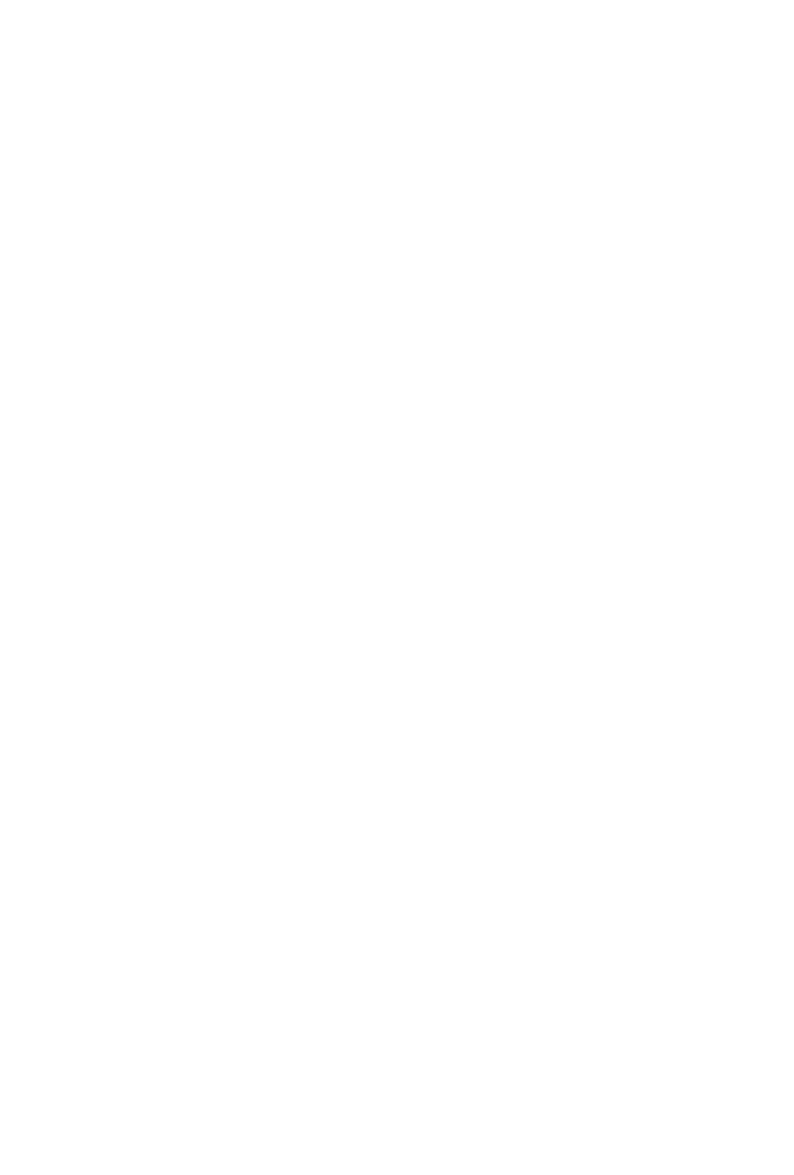

In [92]:
train_dataset = KeyPointsDataset(
    train_keys, train_aug, workers=2, use_multiprocessing=True
)
validation_dataset = KeyPointsDataset(
    validation_keys, test_aug, train=False, workers=2, use_multiprocessing=True
)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
#assert sample_keypoints.max() == 1.0
#assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 5, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

## Model building

The [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) (on which
the StanfordExtra dataset is based) was built using the [ImageNet-1k dataset](http://image-net.org/).
So, it is likely that the models pretrained on the ImageNet-1k dataset would be useful
for this task. We will use a MobileNetV2 pre-trained on this dataset as a backbone to
extract meaningful features from the images and then pass those to a custom regression
head for predicting coordinates.

In [88]:

def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")


Our custom network is fully-convolutional which makes it more parameter-friendly than the
same version of the network having fully-connected dense layers.

In [89]:
get_model().summary()

<ipython-input-88-d3d42896bf34>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "keypoint_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 640, 640, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 640, 640, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 640, 640, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 20, 20, 1280)        │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 1280)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 16, 16, 10)          │          44,810 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 14, 14, 10)          │             200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,302,994 (8.79 MB)

 Trainable params: 45,010 (175.82 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Notice the output shape of the network: `(None, 1, 1, 48)`. This is why we have reshaped
the coordinates as: `batch_keypoints[i, :] = np.array(kp_temp).reshape(1, 1, 24 * 2)`.

## Model compilation and training

For this example, we will train the network only for five epochs.

In [ ]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 191s 994ms/step - loss: 0.1089 - val_loss: 0.0890
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - loss: 0.0821 - val_loss: 0.0770
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - loss: 0.0768 - val_loss: 0.0725
Epoch 4/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - loss: 0.0748 - val_loss: 0.0701
Epoch 5/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 160s 935ms/step - loss: 0.0729 - val_loss: 0.0687


## Make predictions and visualize them

In [ ]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 24, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)

Predictions will likely improve with more training.

## Going further

* Try using other augmentation transforms from `imgaug` to investigate how that changes
the results.
* Here, we transferred the features from the pre-trained network linearly that is we did
not [fine-tune](https://keras.io/guides/transfer_learning/) it. You are encouraged to fine-tune it on this task and see if that
improves the performance. You can also try different architectures and see how they
affect the final performance.